# **London Housing Prices - Exploratory Data Analysis**

In [London_Housing_Descriptives.ipynb](https://github.com/kohl-carmen/London-Housing_Descriptives/blob/main/London_Housing.ipynb), we had a first look at London property sales data. We found that there are large differences in house prices across the different boroughs. 

Here, we will get new data to try to predict average London house prices.

*Data provided by [London Datastore](https://data.london.gov.uk/). 
[License](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/) terms apply.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split



---


# 1) Data Loading and Cleaning





First, we'll load any data which may help us predict house prices per borough (all taken from [London Datastore](https://data.london.gov.uk/)), and edit the data to make sure they're all in the same format.

For this, we'll select data with the following information per borough:
- [Average House Prices](https://data.london.gov.uk/dataset/uk-house-price-index): This is the data we're most interested in and already had a look through [here](https://github.com/kohl-carmen/London-Housing/blob/main/London_Housing.ipynb)
- [Population](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough): Number of inhabitants
- [Personal Wellbeing](https://data.london.gov.uk/dataset/subjective-personal-well-being-borough): Estimates of personal well-being from the Annual Population Survey Well-being dataset
- [Crime Rates](https://data.london.gov.uk/dataset/recorded_crime_rates): Number of recorded offences
- [Employment](https://data.london.gov.uk/dataset/workless-households-borough): Proportions of households that are classified as working
- [Life expectancy](https://data.london.gov.uk/dataset/london-ward-well-being-scores): life expectancy in years
- [Childhood obesity rates](https://data.london.gov.uk/dataset/london-ward-well-being-scores): proportion of children with obesity
- [Incapacity Benefit rates](https://data.london.gov.uk/dataset/london-ward-well-being-scores): poportion of population receiving incapacity benefits
- [Unemployment rates](https://data.london.gov.uk/dataset/london-ward-well-being-scores): proportion of unemployment
- [GCSE performance](https://data.london.gov.uk/dataset/london-ward-well-being-scores): GCSE point scores
- [Absence from School](https://data.london.gov.uk/dataset/london-ward-well-being-scores): percentage of unauthorised absences from school
- [Number of children in unemployed households](https://data.london.gov.uk/dataset/london-ward-well-being-scores): percentage of children in out-of-work households
- [Transport Accessibility](https://data.london.gov.uk/dataset/london-ward-well-being-scores): public transport accessibility



These data are all longitudinal and borough-specific. However, they are formatted in a number of different ways, and contain a lot of data we will not be using. The first step is therefore to load, clean and edit the data so that all data has the same format.

We'll also load some data which is not longitudinal:

- [Area](https://data.london.gov.uk/dataset/london-borough-profiles): Land area in hectars
- [Longitude](https://data.london.gov.uk/dataset/mylondon): Longitude of centre point
- [Transport Zone](https://data.london.gov.uk/dataset/mylondon): TFL Zone averaged over wards


In [ ]:
# - load & format data: house prices - 
data_url = 'https://data.london.gov.uk/download/uk-house-price-index/70ac0766-8902-4eb5-aab5-01951aaed773/UK_House_price_index.xlsx'
df_average_price = pd.read_excel(data_url, sheet_name = 'Average price',
                                 usecols = "A:AH, AJ, AK, AM:AU, AW")
df_average_price = df_average_price.drop(df_average_price.index[0])
# format date column and make it index
df_average_price.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
df_average_price.Date = pd.to_datetime(df_average_price.Date)
df_average_price = df_average_price.set_index('Date')
# check for missing values
df_average_price. isnull().values.any()
# express in thousands
df_average_price = df_average_price.div(1000)
# standardise string formatting
for key in df_average_price:
  if key.isupper():
    newkey = key[0] + key[1:].lower()
    if ' ' in key:
      for s in range(0,len(newkey)):
        if newkey[s].isspace():
          newkey = newkey[0:s+1] + newkey[s+1].upper() + newkey[s+2:]
    df_average_price = df_average_price.rename(columns={key: newkey})
rows, columns = df_average_price.shape
df_average_price = df_average_price.iloc[:,0:33]
df_average_price = df_average_price.sort_index(axis=1)
#df_average_price.head(5)

In [ ]:
# - load & format data: population-
data_url = 'https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/cc4e7e08-3071-488f-bdd9-a62cb1ed1c5c/land-area-population-density-london.xlsx'
# load as separate dfs and join
df_pop1 = pd.read_excel(data_url, sheet_name=str('Borough staging'), 
                        usecols = "B,C,E")
df_pop2 = pd.read_excel(data_url, sheet_name=str('Borough staging'), 
                        usecols = "I,K,N")
df_pop2 = df_pop2.dropna(axis=0, how='any')
df_pop2 = df_pop2.rename(columns = {'Unnamed: 8':'Name',
                                    'Unnamed: 10':'Population',
                                    'Year.1':'Year'})
df_pop = pd.concat([df_pop1,df_pop2], axis=0)
df_pop = df_pop[df_pop.Year <= 2020] # delete future projections
# sort into df of matched format
date = pd.unique(df_pop.Year)
df_pop_format = pd.DataFrame(index = pd.unique(df_pop.Year), 
                             columns = pd.unique(df_pop.Name))
df_pop_format = df_pop_format.fillna(np.nan)
for row in range(0,len(df_pop)):
  this_borough = df_pop.Name.iloc[row]
  this_pop = df_pop.Population.iloc[row]
  this_year = df_pop.Year.iloc[row]
  row_index = np.argwhere(date==this_year)
  col_index = np.argwhere(df_pop_format.columns == this_borough) 
  df_pop_format.iloc[row_index[0],col_index[0]] = this_pop
df_pop_format = df_pop_format.drop(labels=['London','Inner London',
                                           'Outer London'], axis=1)
# edit date ans et as index
df_pop_format['Date']=''
for i in range(0,df_pop_format.shape[0]):
  df_pop_format.iloc[i,-1] = pd.to_datetime(str(int(df_pop_format.index[i]))
                                                +'0101')
df_pop_format = df_pop_format.set_index('Date')
df_population = df_pop_format.copy()
df_population = df_population.sort_index(axis=1)
#df_population.head(5)

In [ ]:
# - load & format data: wellbeing data -
data_url = 'https://data.london.gov.uk/download/subjective-personal-well-being-borough/d1bae8e8-f07b-4c2f-aec7-deed8006b52a/personal-well-being-borough.xlsx'
df_wellbeing = pd.read_excel(data_url, sheet_name = 'Summary - Mean Scores')
# edit df format
df_wellbeing = df_wellbeing.transpose()
df_wellbeing.columns = df_wellbeing.iloc[1,:]
df_wellbeing = df_wellbeing.rename(columns = {'Area': 'Date'}, inplace = False)
df_wellbeing = df_wellbeing.drop([' ', 'Unnamed: 1'])
df_wellbeing = df_wellbeing.dropna(axis=1, how = 'all')
df_wellbeing = df_wellbeing.iloc[0:8,0:34]
# edit datetime and set index
for i in range(0,len(df_wellbeing.Date)):
  df_wellbeing.Date[i] = pd.to_datetime(df_wellbeing.Date[i][0:4])
  df_wellbeing['City of London'][i] = np.nan
df_wellbeing = df_wellbeing.set_index('Date')
df_wellbeing = df_wellbeing.sort_index(axis=1)
#df_wellbeing.head(5)

In [ ]:
# - load & format data: crime rates -
data_url = 'https://data.london.gov.uk/download/recorded_crime_rates/25f3c04c-898a-41c9-b911-93cac6df205f/met-police-recorded-offences-rates-borough.xlsx'
df_crime = pd.read_excel(data_url, sheet_name = 'Recorded Offences')
# edit df format
df_crime = df_crime.iloc[0:34,0:20]
df_crime = df_crime.transpose()
df_crime.columns = df_crime.iloc[1,:]
df_crime = df_crime.drop(['Unnamed: 0','Unnamed: 1'])
df_crime = df_crime.dropna(axis=1, how = 'all')
df_crime =df_crime.rename(columns = {'Borough': 'Date'})
# edit datetime and set index
for i in range(0,len(df_crime.Date)):
  df_crime.Date[i] = pd.to_datetime(df_crime.Date[i][0:4])
df_crime = df_crime.set_index('Date')
df_crime = df_crime.sort_index(axis=1)
#df_crime.head(5)

In [ ]:
# - load & format data: working households -
data_url = 'https://data.london.gov.uk/download/workless-households-borough/e38fa13b-eea2-425f-a97f-52f8f722e73d/workless-households-borough.xlsx'
df_work = pd.DataFrame(columns = df_crime.columns)
df_work['Date']=''
Date = []
# load each year
for yr in range(2004, 2019+1):
  df_borough = pd.read_excel(data_url, sheet_name=str(yr), usecols = "B,D")
  df_borough = df_borough.iloc[3:36,:]
  df_borough = df_borough.transpose()
  df_borough.columns = df_borough.iloc[0,:]
  df_borough = df_borough.iloc[1,:]
  df_work = df_work.append(df_borough)
  Date.append(pd.to_datetime(str(yr)+'-01-01'))
# set datetime index
df_work['Date'] = Date
df_work = df_work.set_index('Date')
df_work[df_work=='!']=np.nan
df_work = df_work.sort_index(axis=1)
#df_work.head(5)

In [ ]:
# - load & format data: several socioeconomic datasets -
data_url = 'https://data.london.gov.uk/download/london-ward-well-being-scores/45c7421c-c6de-4ffd-8484-eed623c1731d/london-ward-well-being-probability-scores.xls'
df_lifeexpectancy = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,E:I', skiprows = 628)
df_childhoodobesity = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,J:N', skiprows = 628)
df_incapacitybenefit = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,O:S', skiprows = 628)
df_unemployment = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,T:X', skiprows = 628)
df_gcse = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AI:AM', skiprows = 628)
df_schoolabsence = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AN:AR', skiprows = 628)
df_worklesshouseholdchildren = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AS:AW', skiprows = 628)
df_transport = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AX:BB', skiprows = 628)

# edit format
def tidy_df(df):
  df = df.iloc[:32,:]
  df = df.rename(columns={df.columns[0]:'',df.columns[1]:'2009',
                         df.columns[2]:'2010',df.columns[3]:'2011',
                         df.columns[4]:'2012',df.columns[5]:'2013'})
  df = df.transpose()
  df.index = pd.to_datetime(df.index)
  df.columns = df.iloc[0,:]
  df = df.iloc[1:,:]
  return df

df_lifeexpectancy = tidy_df(df_lifeexpectancy)
df_childhoodobesity = tidy_df(df_childhoodobesity)
df_incapacitybenefit = tidy_df(df_incapacitybenefit)
df_unemployment = tidy_df(df_unemployment)
df_gcse = tidy_df(df_gcse)
df_schoolabsence = tidy_df(df_schoolabsence)
df_worklesshouseholdchildren = tidy_df(df_worklesshouseholdchildren)
df_transport = tidy_df(df_transport)

In [ ]:
# - load & format data: transport -
data_url = 'https://data.london.gov.uk/download/mylondon/5ff9ce59-2a77-456a-9ecc-f8fb80660ef1/MyLondon_fare_zone_OA.csv'
df_transportzone = pd.read_csv(data_url)
# get borough labels from associated set
data_url = 'https://data.london.gov.uk/download/mylondon/a72ae909-56d1-4e2a-9d37-8abb0260775a/summary.csv'
df_borough_labels = pd.read_csv(data_url)
labels = []
for row in range(0,len(df_transportzone)):
  label = df_borough_labels.LAD[df_borough_labels.OA==
                                df_transportzone.OA11CD[row]]
  vars(label)
  idx = str(dict(label)).find("'")
  labels.append(str(dict(label))[idx+1:-2])
df_transportzone['Borough'] = labels
df_transportzone = df_transportzone.sort_values(by='Borough')
zone = []
for borough in np.unique(df_transportzone.Borough):
    meanzone = np.mean(df_transportzone['Fare_Zone']
                       [df_transportzone.Borough==borough])
    zone.append(meanzone)   
df_transportzone = df_transportzone.drop(columns=['OA11CD','Fare_Zone'])  
df_transportzone = df_transportzone.drop_duplicates()              
df_transportzone['zone'] = zone

df_transportzone = df_transportzone.transpose()
df_transportzone.columns = df_transportzone.iloc[0,:]
df_transportzone = df_transportzone.drop('Borough')
# df_transportzone.head(5)

In [ ]:
# - load & format data: area -
data_url = 'https://data.london.gov.uk/download/london-borough-profiles/80647ce7-14f3-4e31-b1cd-d5f7ea3553be/london-borough-profiles.xlsx'
df_area = pd.read_excel(data_url, sheet_name = 'Data',
                                 usecols = "C,E,G,AD,")
# drop unused data
df_area = df_area.iloc[1:34]
df_area = df_area.transpose()
df_area.columns = df_area.iloc[0,:]
df_area = df_area.drop('Area name')
df_area = df_area.iloc[0:2,:]
df_area = df_area.sort_index(axis=1)
df_area = df_area.rename({'Inland Area (Hectares)':'area'})
#df_area.head(5)

In [ ]:
# - load & format data: longitude -
data_url = 'https://data.london.gov.uk/download/mylondon/d62ad9f3-4a5d-410b-993a-134c57ce52ee/bbox.csv'
df_location = pd.read_csv(data_url)
labels = []
for row in range(0,len(df_location)):
  label = df_borough_labels.LAD[df_borough_labels.OA==df_location.oa[row]]
  vars(label)
  idx = str(dict(label)).find("'")
  labels.append(str(dict(label))[idx+1:-2])
df_location['Borough'] = labels
df_location = df_location.iloc[:,8:]
longitude = []
latitude = []
for borough in np.unique(df_location.Borough):
    meanlong = np.mean(df_location['Longitude'][df_location.Borough==borough])
    meanlat = np.mean(df_location['Latitude'][df_location.Borough==borough])
    longitude.append(meanlong)  
    latitude.append(meanlat)  
df_location['Longitude'] = ''
df_location['Latitude'] = ''
df_location = df_location.drop_duplicates()
df_longlat = df_location.copy()
df_longlat['Longitude'] = longitude
df_longlat['Latitude'] = latitude
df_longlat = df_longlat.transpose()
df_longlat.columns = df_longlat.iloc[2,:]
df_longlat = df_longlat.iloc[0:2,:]
df_longlat = df_longlat.rename({'Latitude':'latitude','Longitude':'longitude'})
# df_longlat.head(5)



---
# 2) Data matching 


We have now loaded all the data and made sure to put them into time-by-borough
dataframes. However, they are not yet matched perfectly.

First, we'll make sure the borough labels follow the same spelling in all dataframes.

In [ ]:
# Match spelling of boroughs
def rename_borough(df):
  for borough in df:
    if '&' in borough:
      index = borough.find('&')
      new_label = borough[0:index]+'and'+borough[index+1:]
      df = df.rename(columns={borough: new_label})
  return df

df_average_price = rename_borough(df_average_price)
df_population = rename_borough(df_population)
df_wellbeing = rename_borough(df_wellbeing)
df_crime = rename_borough(df_crime)
df_work = rename_borough(df_work)
df_area = rename_borough(df_area)
df_lifeexpectancy = rename_borough(df_lifeexpectancy)
df_childhoodobesity = rename_borough(df_childhoodobesity)
df_incapacitybenefit = rename_borough(df_incapacitybenefit)
df_unemployment = rename_borough(df_unemployment)
df_gcse = rename_borough(df_gcse)
df_schoolabsence = rename_borough(df_schoolabsence)
df_worklesshouseholdchildren = rename_borough(df_worklesshouseholdchildren)
df_transport = rename_borough(df_transport)
df_transportzone = rename_borough(df_transportzone)
df_longlat = rename_borough(df_longlat)

Next, we'll delete boroughs with missing values.

In [ ]:
# delete borough if is missing entirely or has missing values in any set
boroughs_to_delete = []
all_variables = ['df_average_price','df_wellbeing','df_crime','df_work',
                 'df_population','df_lifeexpectancy','df_childhoodobesity',
                 'df_incapacitybenefit','df_unemployment','df_gcse',
                 'df_schoolabsence','df_worklesshouseholdchildren',
                 'df_transport','df_transportzone','df_area','df_longlat']
cols = df_average_price.shape[1]
for df_str in all_variables:
  df = eval(df_str)
  if df.shape[1] != cols:
    for borough in df_average_price:
      if borough not in df:
        boroughs_to_delete.append(borough)

# check for missing values
for df_str in all_variables:
  df = eval(df_str)
  for borough in df:
     if sum(df[borough].isna()) > 0:
       boroughs_to_delete.append(borough)

boroughs_to_delete = np.unique(boroughs_to_delete)

def delete_missing_vals(df,boroughs_to_delete):
  for delete in boroughs_to_delete:
    delete = str(delete)
    if delete in df:
      df = df.drop([delete], axis=1)
  return df

df_average_price = delete_missing_vals(df_average_price,boroughs_to_delete)
df_population = delete_missing_vals(df_population,boroughs_to_delete)
df_wellbeing = delete_missing_vals(df_wellbeing,boroughs_to_delete)
df_crime = delete_missing_vals(df_crime,boroughs_to_delete)
df_work = delete_missing_vals(df_work,boroughs_to_delete)
df_area = delete_missing_vals(df_area,boroughs_to_delete)
df_lifeexpectancy = delete_missing_vals(df_lifeexpectancy,boroughs_to_delete)
df_childhoodobesity = delete_missing_vals(df_childhoodobesity,
                                          boroughs_to_delete)
df_incapacitybenefit = delete_missing_vals(df_incapacitybenefit,
                                           boroughs_to_delete)
df_unemployment = delete_missing_vals(df_unemployment,boroughs_to_delete)
df_gcse = delete_missing_vals(df_gcse,boroughs_to_delete)
df_schoolabsence = delete_missing_vals(df_schoolabsence,boroughs_to_delete)
df_worklesshouseholdchildren = delete_missing_vals(df_worklesshouseholdchildren,
                                                   boroughs_to_delete)
df_transport = delete_missing_vals(df_transport,boroughs_to_delete)
df_transportzone = delete_missing_vals(df_transportzone, 
                                            boroughs_to_delete)
df_longlat = delete_missing_vals(df_longlat, boroughs_to_delete)
for borough in boroughs_to_delete:
  print('Deleted: '+ borough)

Deleted: City of London


Now the columns of all dataframes should be matched! We'll sanity-check this here:

In [ ]:
# check column matching - print if wrong
for col in range(0,df_average_price.shape[1]):
  borough = df_average_price.columns[col]
  for df in all_variables:
    if eval(df).columns[col] != borough:
      print(df)
      print(borough)

The last step of data editing is to match the time points at which data is presented. Since all dataframes besides the one containing house prices only provide on set of data per year, we'll average house prices over months to match.






In [ ]:
# match dates (most data sets only have one record per year)
# take mean per year in price data to match
df_average_price_yr = pd.DataFrame(columns=df_average_price.columns)
for yr in range(min(df_average_price.index).year,
                max(df_average_price.index).year+1):
  add = {}
  add.update({'Year':yr})
  for region in df_average_price:
    sales = df_average_price[region][df_average_price[region].index.year == yr].mean()
    add.update({region:sales})
  df_average_price_yr = df_average_price_yr.append(add,ignore_index=True)
df_average_price_yr = df_average_price_yr.set_index('Year')
df_average_price_yr['Date'] = ''
for i in range(0,df_average_price_yr.shape[0]):
  floatyear = df_average_price_yr.index[i]
  df_average_price_yr.iloc[i,-1] = pd.to_datetime(str(int(floatyear))+'0101')
df_average_price_yr = df_average_price_yr.set_index('Date')
df_average_price = df_average_price_yr.copy()
 

Unfortunately, we are unable to match the time steps perfectly, since these data were collected over different periods of time. We'll print the years for which we have data for each set.

In [ ]:
# check available dates
for df_str in all_variables:
  df = eval(df_str)
  if df.shape[0] > 3:
    print(df_str+': '+ str(df.shape[0])+ ' samples between ' + 
          str(df.index.year.min()) + ' and '+ str(df.index.year.max()))
  else:
    print(df_str+': No time samples')

df_average_price: 26 samples between 1995 and 2020
df_wellbeing: 8 samples between 2011 and 2018
df_crime: 18 samples between 1999 and 2016
df_work: 16 samples between 2004 and 2019
df_population: 22 samples between 1999 and 2020
df_lifeexpectancy: 5 samples between 2009 and 2013
df_childhoodobesity: 5 samples between 2009 and 2013
df_incapacitybenefit: 5 samples between 2009 and 2013
df_unemployment: 5 samples between 2009 and 2013
df_gcse: 5 samples between 2009 and 2013
df_schoolabsence: 5 samples between 2009 and 2013
df_worklesshouseholdchildren: 5 samples between 2009 and 2013
df_transport: 5 samples between 2009 and 2013
df_transportzone: No time samples
df_area: No time samples
df_longlat: No time samples




---


# 3) Data Inspection & Feature Engineering


Now that the data is ready, we'll plot each set to check that everything looks sensible.

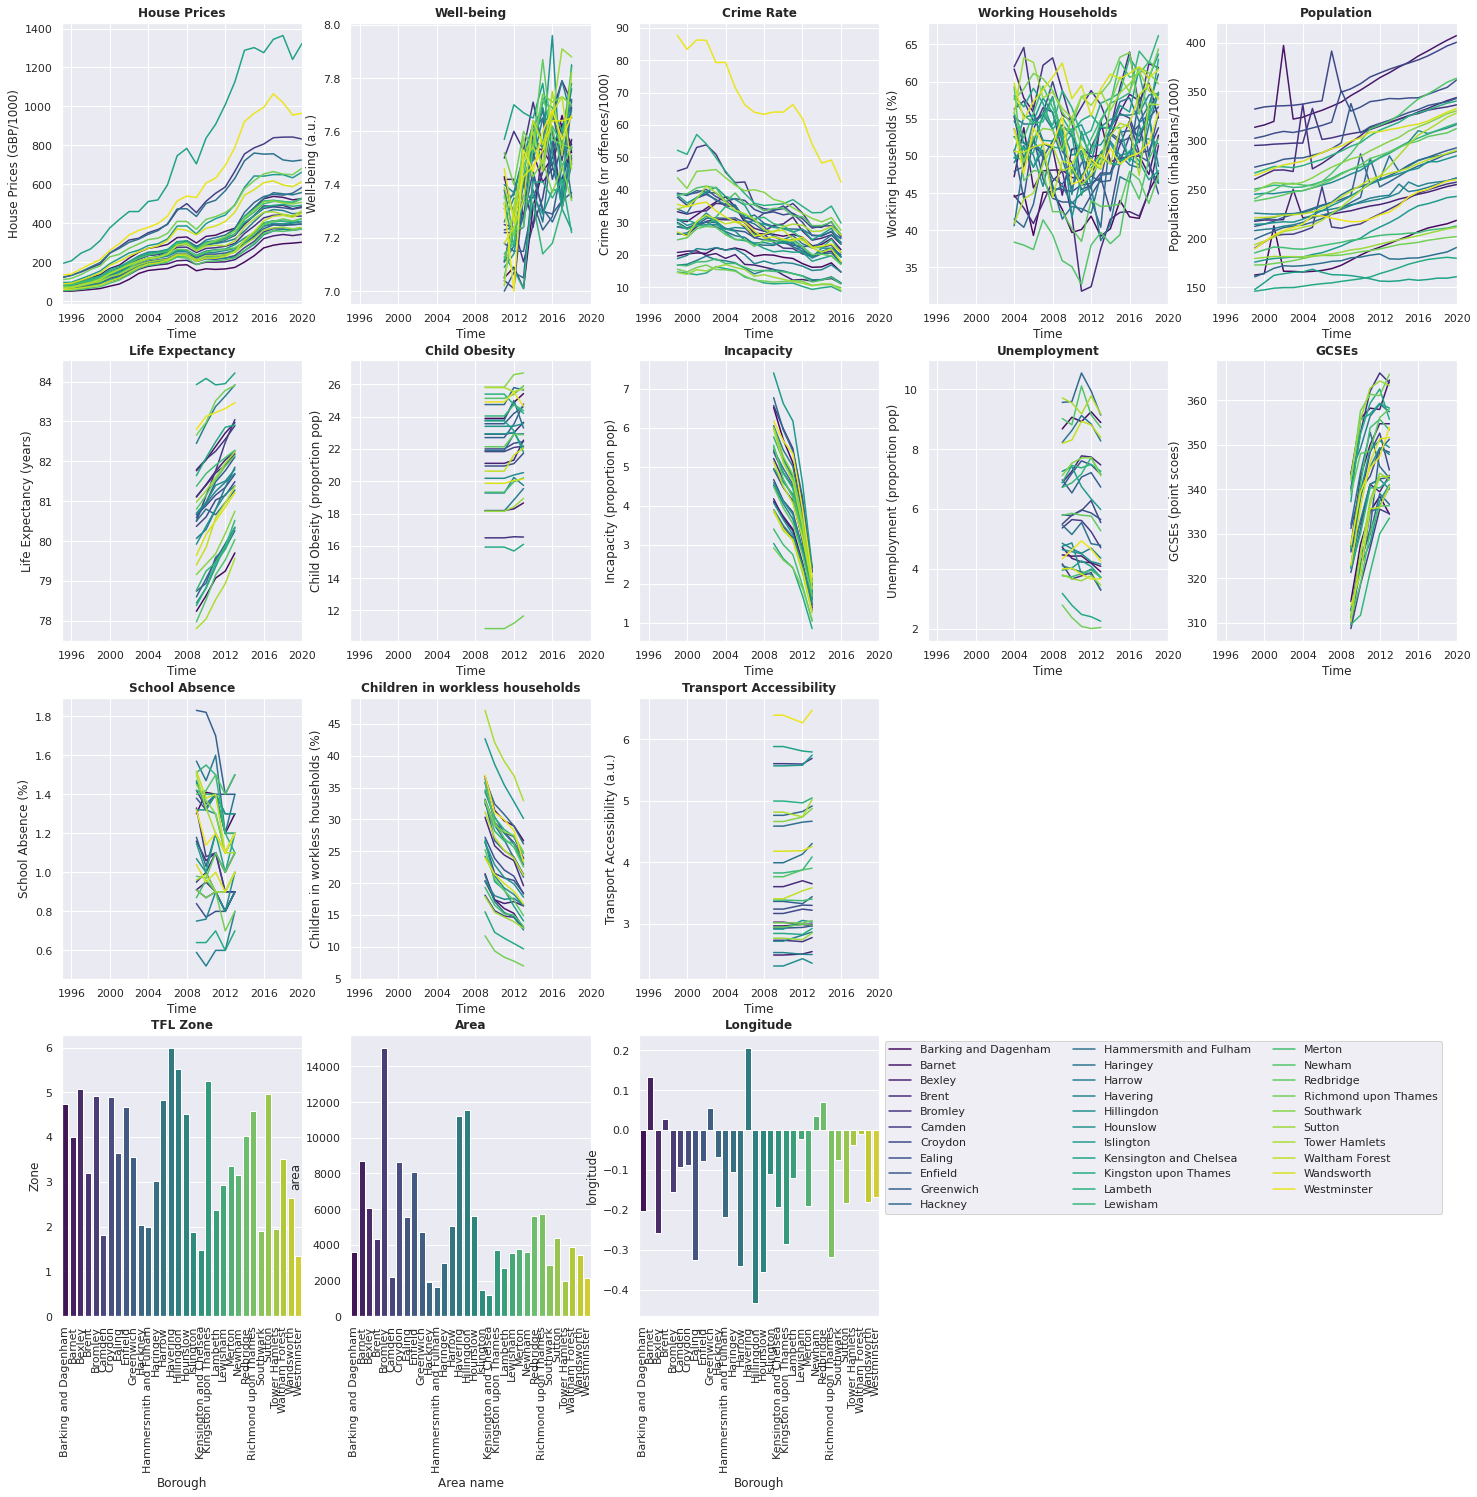

In [ ]:
def plot_all(df):
  count = 0
  my_cmap = sns.color_palette('viridis', n_colors = len(list(df)))
  for borough in df:
    plt.plot(df[borough], color = my_cmap[count])
    count += 1

sns.set(rc={'figure.figsize':(25,30)})
variables_time = all_variables[:-3]
variables_snap = all_variables [-3:]
variables_time_titles = ['House Prices','Well-being','Crime Rate',
             'Working Households','Population','Life Expectancy',
             'Child Obesity','Incapacity','Unemployment','GCSEs',
             'School Absence','Children in workless households',
             'Transport Accessibility']
variables_snap_titles = ['TFL Zone','Area','Longitude']
variables_time_units = ['GBP/1000','a.u.','nr offences/1000','%','inhabitans/1000',
            'years','proportion pop','proportion pop','proportion pop',
            'point scoes','%','%','a.u.']

# plot variables over time
count = 0
for df_str in variables_time:
  df = eval(df_str)
  if  df_str=='df_crime' or df_str=='df_population':
    df = df.div(1000)
  count += 1
  plt.subplot(5,5,count)
  plot_all(df)
  plt.title(variables_time_titles[count-1],fontweight='bold')
  plt.xlim([pd.to_datetime(str(1995)+'0101'),pd.to_datetime(str(2020)+'0101')])
  plt.ylabel(variables_time_titles[count-1]+ ' (' + variables_time_units[count-1]+')')
  plt.xlabel('Time')
plt.legend(df.columns,bbox_to_anchor = (1, -.2),ncol = 3, loc='upper left')

# plot remaining variables
snap_count = 0
for df_str in variables_snap:
  df = eval(df_str)
  plt.subplot(5,5,count+3)
  count += 1
  snap_count += 1
  idx = 1
  if df_str == 'df_transportzone':
    idx = 0
  bars = sns.barplot(x=df.columns,y = df.iloc[idx,:], palette='viridis')
  bars.set_title(variables_snap_titles[snap_count-1],fontweight='bold')
  _ = bars.set_xticklabels(bars.get_xticklabels(),rotation=90)



To get a sense of the overall trend of each dataset, we'll plot the longitudinal data again with an overlaid average.

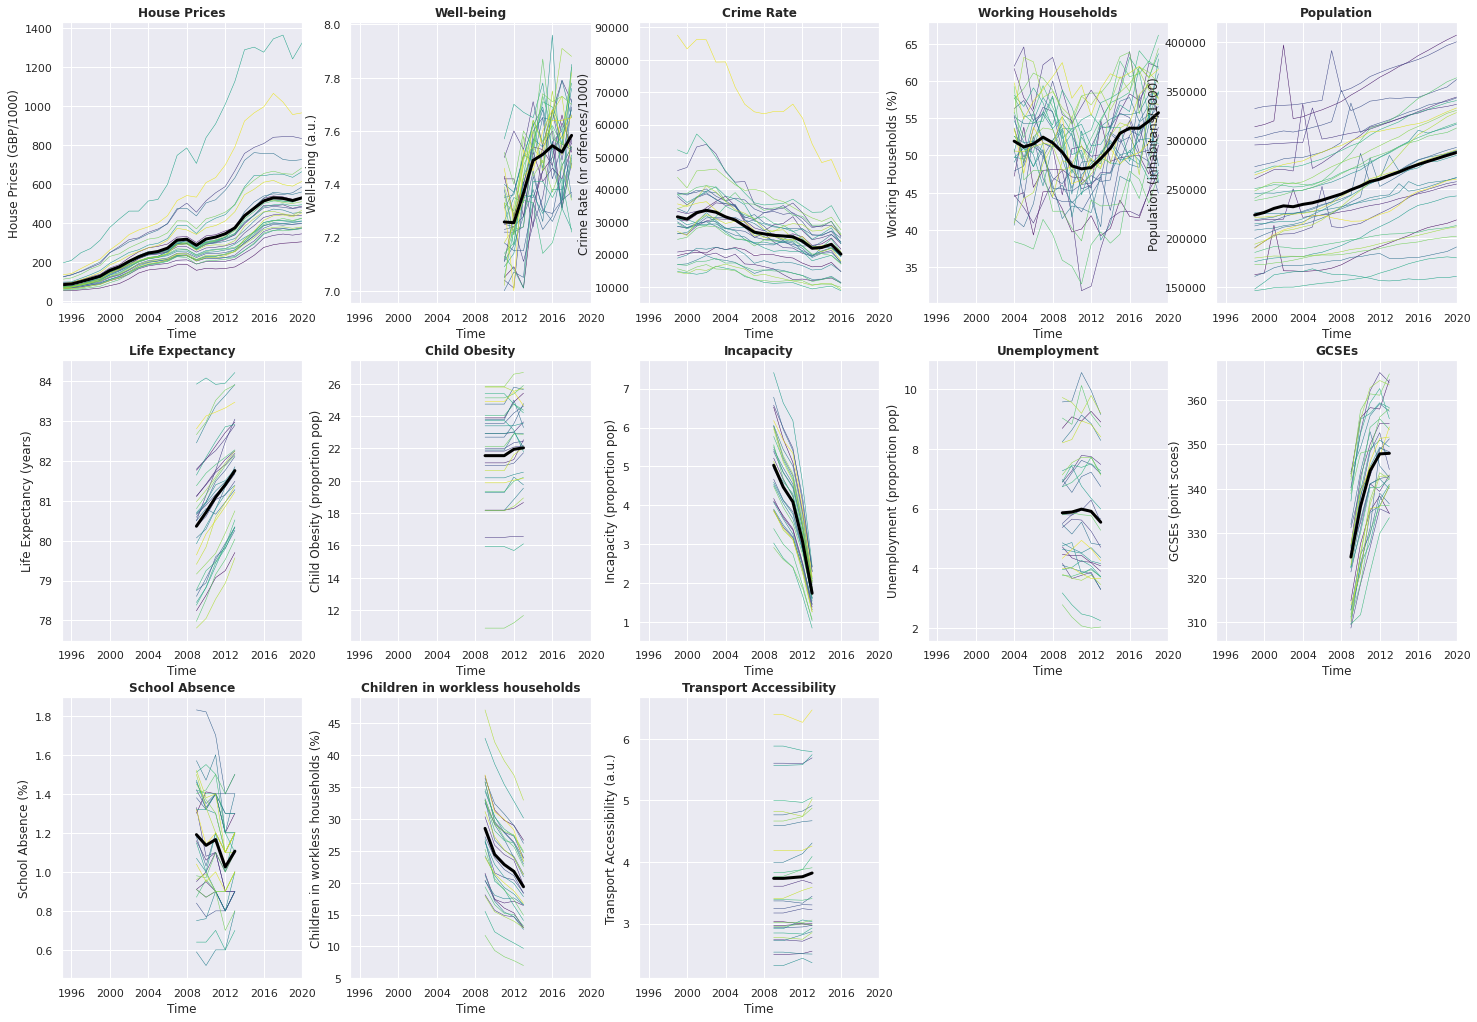

In [ ]:
#repeat figure and add mean
def plot_all(df):
  count = 0
  my_cmap = sns.color_palette('viridis', n_colors = len(list(df)))
  for borough in df:
    plt.plot(df[borough], linewidth=0.5, color = my_cmap[count])
    count += 1

sns.set(rc={'figure.figsize':(25,30)})
count = 0

for df_str in variables_time:
  df = eval(df_str)
  count += 1
  plt.subplot(5,5,count)
  plot_all(df)
  #plot_avg
  plt.plot(df.mean(axis=1),color=[0,0,0],linewidth=3)
  plt.title(variables_time_titles[count-1],fontweight='bold')
  plt.xlim([pd.to_datetime(str(1995)+'0101'),pd.to_datetime(str(2020)+'0101')])
  plt.ylabel(variables_time_titles[count-1]+ ' ('
             + variables_time_units[count-1]+')')
  plt.xlabel('Time')

We can see that all data looks sensible. However, we can also see that most data does not span many years. 

Next, we'll explore the relationship between each dataset and London house prices for all years in which data is available.

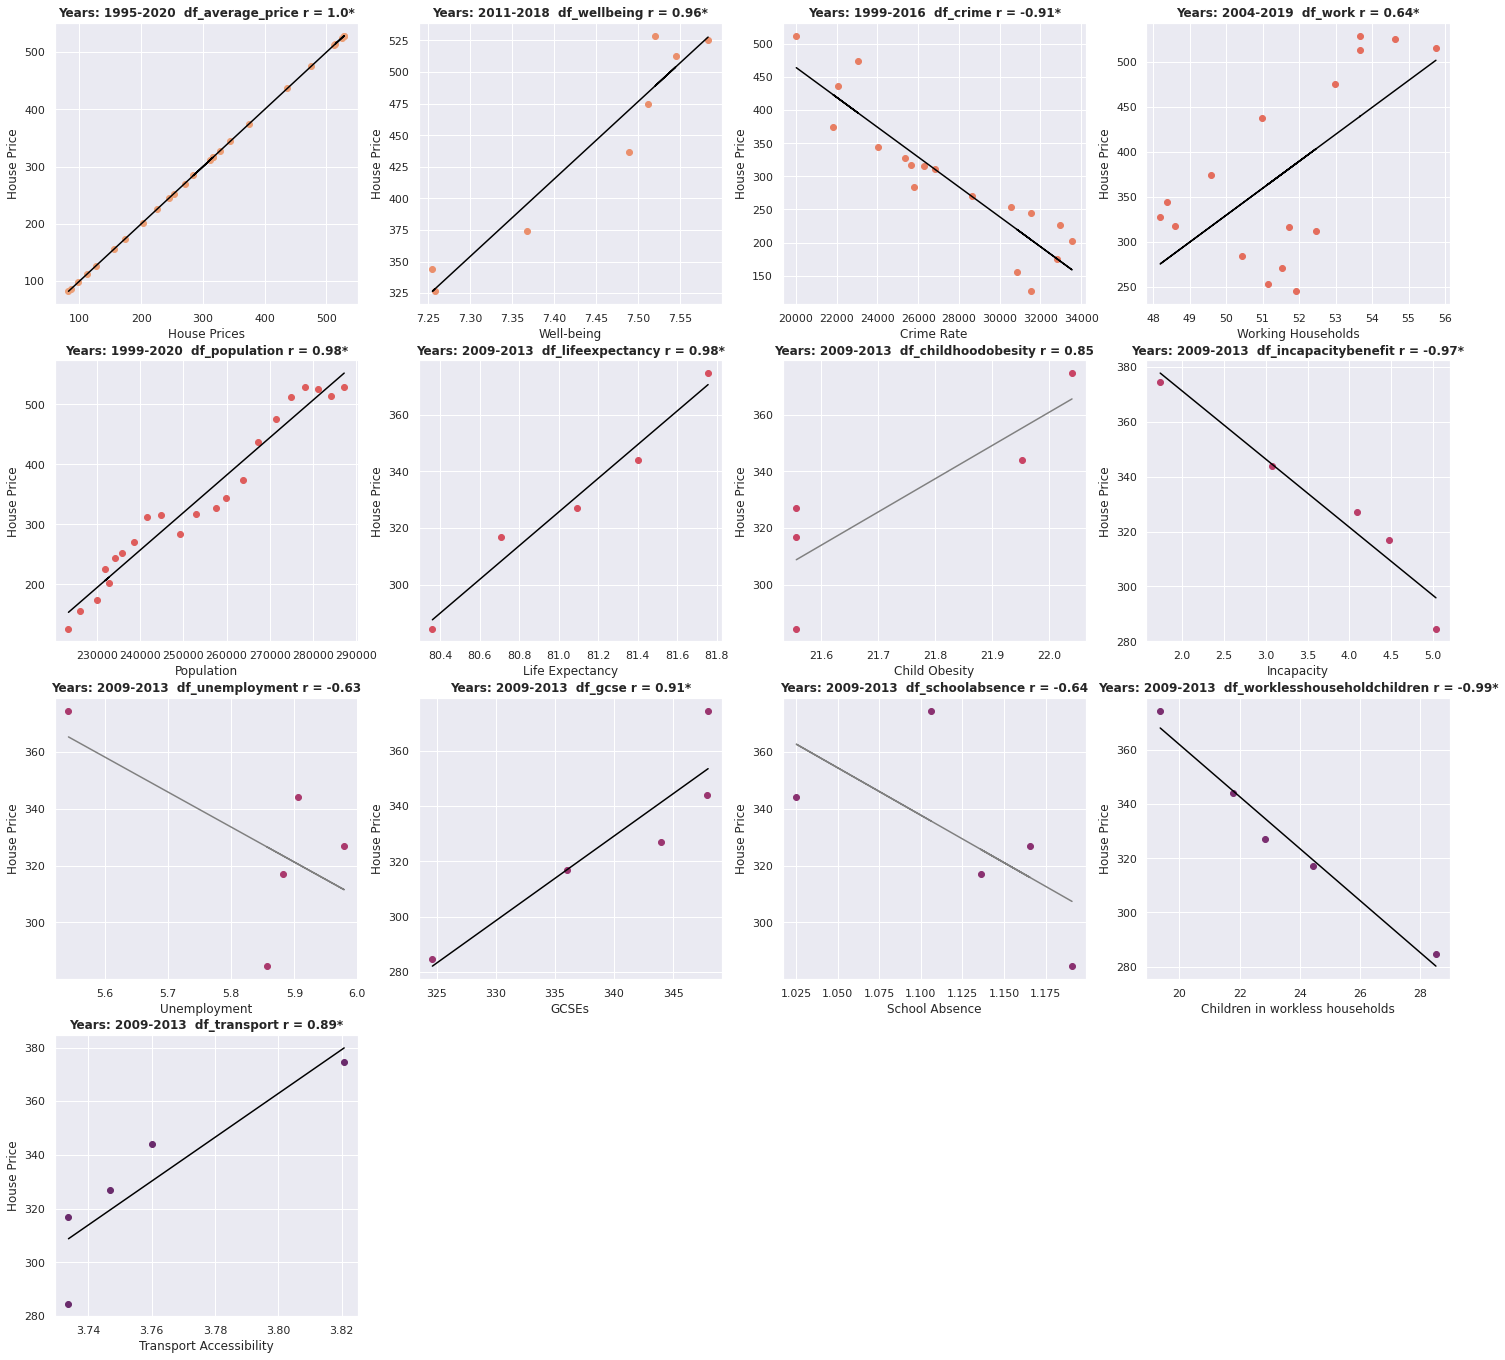

In [ ]:
# plot house prices as a function of each variable
sns.set(rc={'figure.figsize':(25,30)})
my_cmap = sns.color_palette('flare', n_colors = len(variables_time)+1)

def select_matching_years_and_avg(df):
  # find years available in both sets
  shared_min = np.max([df_average_price.index.year.min(), df.index.year.min()])
  shared_max = np.min([df_average_price.index.year.max(), df.index.year.max()])
  price_slice = df_average_price[(df_average_price.index.year >= shared_min) &
                                 (df_average_price.index.year <= shared_max)]
  df_slice = df[(df.index.year >= shared_min) & (df.index.year <= shared_max)]
  df_x = df_slice.mean(axis=1)
  df_y = price_slice.mean(axis=1) 
  return df_x, df_y

# plot bivariate correlations
count = 0
for df_str in variables_time:
  count += 1
  plt.subplot(5,4,count)
  df = eval(df_str)
  df_x, df_y = select_matching_years_and_avg(df)
  plt.scatter(df_x,df_y,color=my_cmap[count-1])
  corr, p = pearsonr(df_x,df_y)
  trendcolor = [.5, .5, .5]
  pstr = ''
  if p < .05:
    trendcolor = [0, 0, 0]
    pstr = '*'
  plt.title('Years: '+ str(df.index.year.min()) +'-'+ str(df.index.year.max())+
            '  '+ variables_time[count-1] + ' r = ' + 
            str(round(corr,2))+pstr,fontweight='bold')
  plt.xlabel(variables_time_titles[count-1])
  plt.ylabel('House Price')
  trend = np.polyfit(np.array(df_x, dtype='float'),
                    np.array(df_y, dtype='float'),1)
  trendpoly = np.poly1d(trend)
  plt.plot(df_x,trendpoly(df_x),color=trendcolor)


We can see that most variables seem somewhat related to London house prices. 
In particular, we can see a strong negative relationship between house prices and crime rates, and a strong positive relationship between house prices and population density. This is unsurprising as safe areas with a high demand for housing drive up prices (but see below).


However, it is now obvious that for most datasets, we do not have enough data to assess it as longitudinal data. Going forward, we'll therefore get rid of the time dimension by picking the latest year shared by all datasets. We'll then test whether some of our variables can predict house prices.



---


We'll use a linear regression model to test whether out variables are able to predict housing prices for different boroughs.

First, we'll select all data for a specific year and combine all data which we believe may help us predict London house prices into one feature dataframe.

In [ ]:
def find_latest_shared_year(feature_str,target_str):
  # find latest shared year
  shared_max = 99999
  feature_target_str = feature_str + target_str
  for variable in feature_target_str:
    df = eval(variable)
    shared_max = np.min([df.index.year.max(), shared_max])
  return shared_max

def drop_and_concat(feature_str,shared_max):
  # drop all other years & concatenate features
  features = pd.DataFrame()
  for feature in feature_str:
    df = eval(feature)
    df = df[(df.index.year == shared_max)]   
    df = df.transpose()   
    df = df.rename(columns={df.columns[0]: feature[3:]})
    features = pd.concat([features,df], axis=1)
  return features

#select features
target_str = ['df_average_price']
np.where(variables_time==target_str)
variables_time.remove(target_str[0])
feature_str = variables_time

# pick year of interest
year = find_latest_shared_year(feature_str,target_str)
features = drop_and_concat(feature_str,year)
target = drop_and_concat(target_str,year)

#add features without time dimension
pd_temp = pd.DataFrame()
for df_str in variables_snap:
  df = eval(df_str)
  pd_temp = pd.concat([pd_temp,df],axis=0)
pd_temp = pd_temp.iloc[[0,2,4],:]
features2 = pd_temp.transpose()

features = pd.concat([features,features2],axis=1)
features = features.astype(float)
features.head(1)

,wellbeing,crime,work,population,lifeexpectancy,childhoodobesity,incapacitybenefit,unemployment,gcse,schoolabsence,worklesshouseholdchildren,transport,Zone,area,longitude
Barking and Dagenham,7.01,16104.0,39.2,194741.0,79.703715,25.428195,2.415305,8.890101,334.4,1.3,26.661031,2.970626,4.748644,3610.7817,-0.203649


Now that we've formatted all the data, we can change them into more meaningful measures where applicable: we'll normalise crime rates by population and transform population data into population density data.

In [ ]:
# crime numbers/population
features.crime = features.crime.divide(features.population)
# calculate population density
features.population = features.population.divide(df_area.iloc[1,:])
features.head(1)

,wellbeing,crime,work,population,lifeexpectancy,childhoodobesity,incapacitybenefit,unemployment,gcse,schoolabsence,worklesshouseholdchildren,transport,Zone,area,longitude
Barking and Dagenham,7.01,0.082694,39.2,53.9332,79.703715,25.428195,2.415305,8.890101,334.4,1.3,26.661031,2.970626,4.748644,3610.7817,-0.203649


We'll now inspect the relationship between house prices and each of the variables.
Note: this is similar to the plot above, however, while we saw the relationships *over time* averaged over boroughs above, we've now  removed the time dimesnion and are looking at the relationships *over boroughs* averaged over time

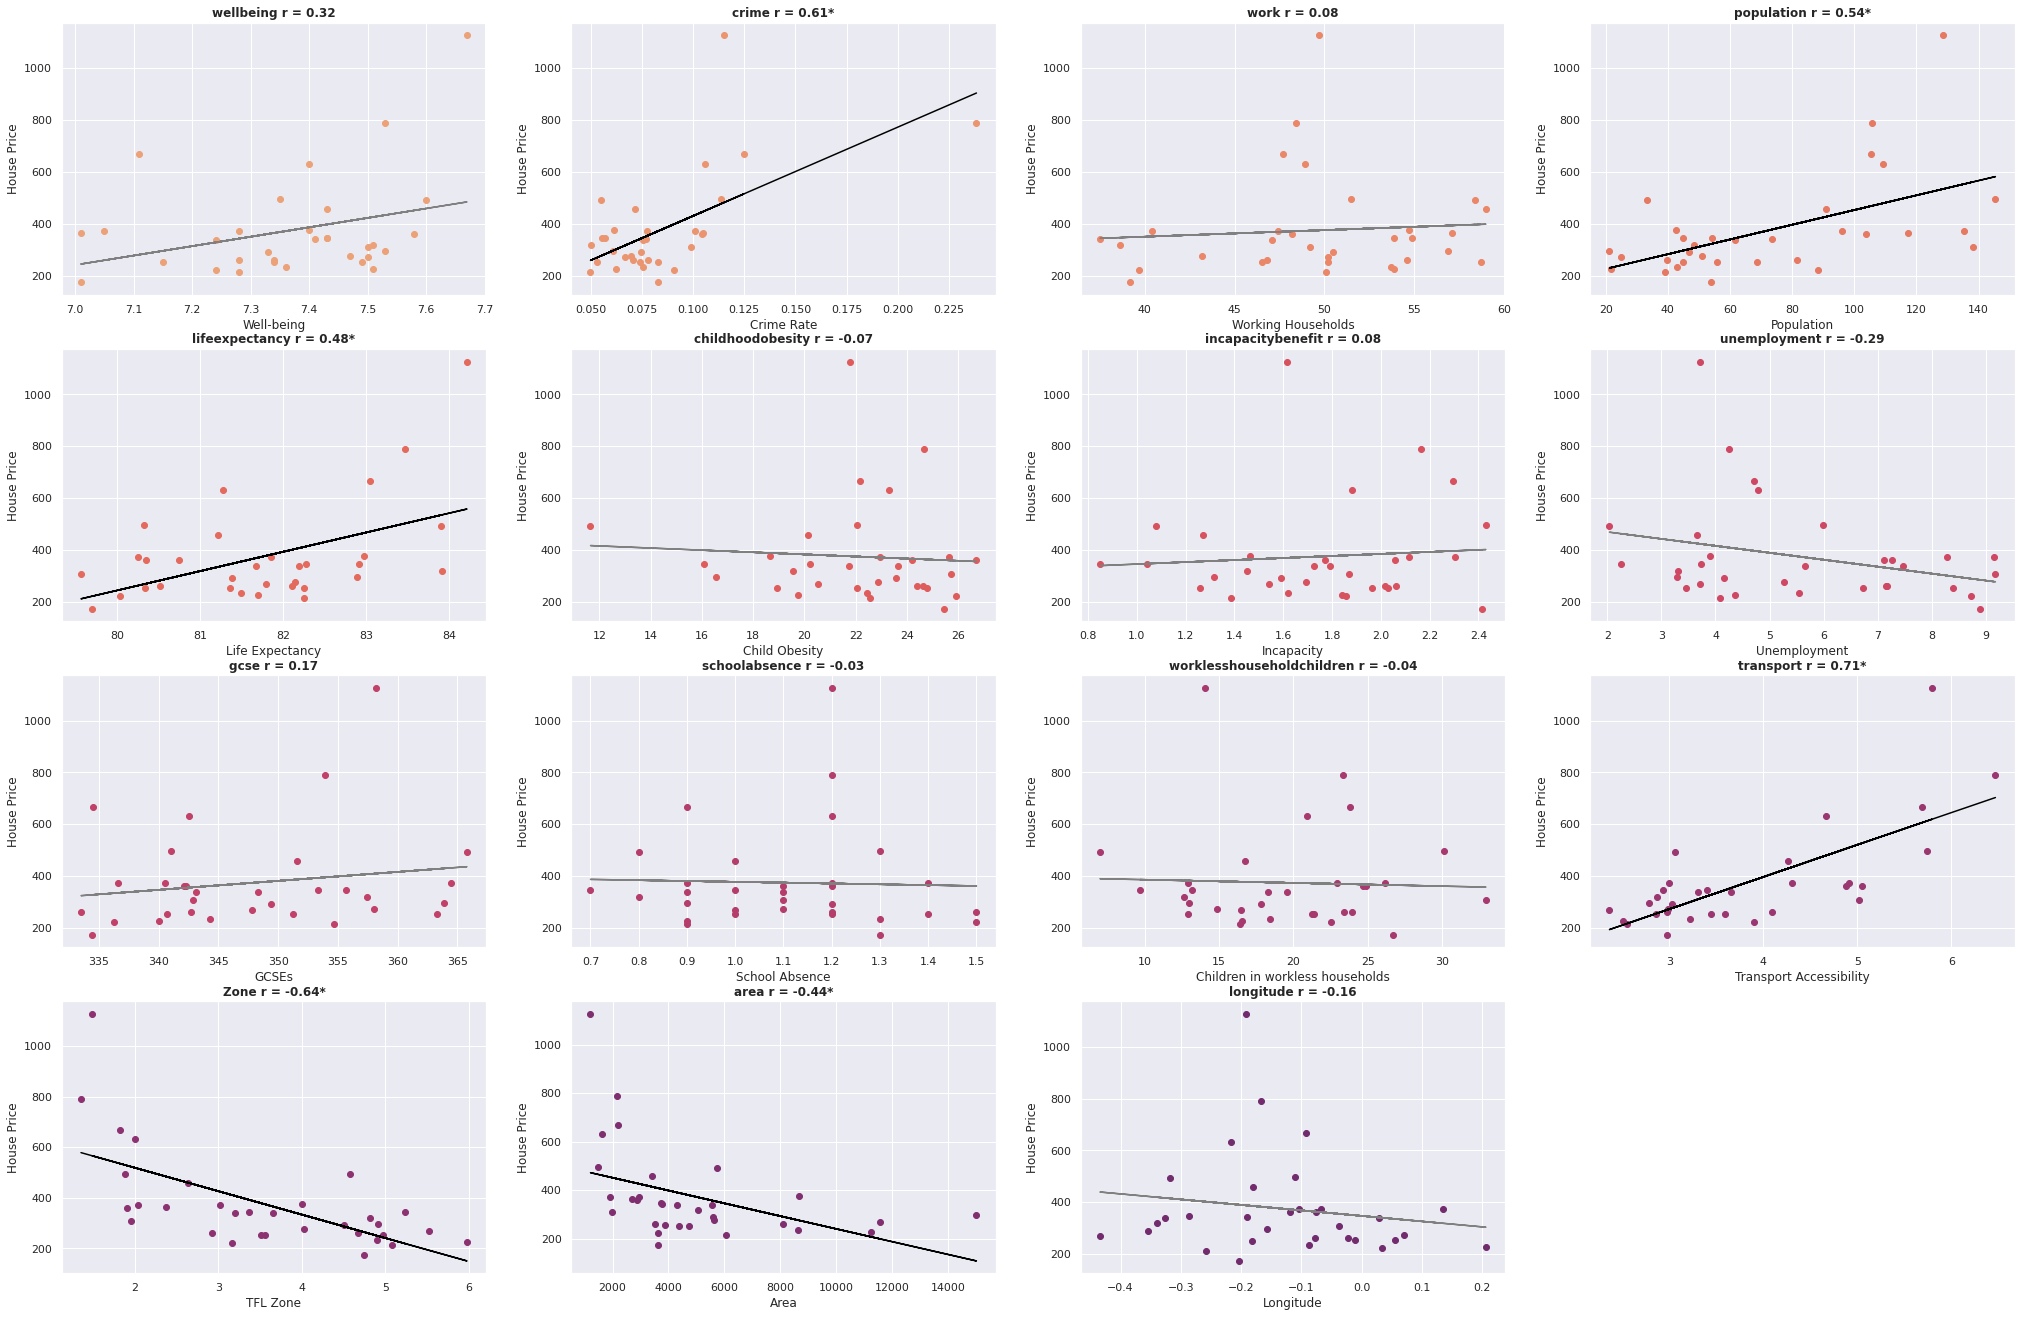

In [ ]:
# each feature with target
sns.set(rc={'figure.figsize':(25,30)})
my_cmap = sns.color_palette('flare', n_colors = len(all_variables)+1)

titles = variables_time_titles[1:] + variables_snap_titles
count = 0
for feature in features:
  count += 1
  plt.subplot(6,4,count)
  df_x = features[feature]
  df_y = target.average_price
  plt.scatter(df_x,df_y,color=my_cmap[count-1])
  corr, p = pearsonr(df_x,df_y)
  trendcolor = [.5, .5, .5]
  pstr = ''
  if p < .05:
    trendcolor = [0, 0, 0]
    pstr='*'
  plt.title(feature + ' r = ' + str(round(corr,2))+pstr,fontweight='bold')
  plt.xlabel(titles[count-1])
  plt.ylabel('House Price')
  trend = np.polyfit(np.array(df_x, dtype='float'),
                    np.array(df_y, dtype='float'),1)
  trendpoly = np.poly1d(trend)
  plt.plot(df_x,trendpoly(df_x),color=trendcolor)

We can see several important things here:
 - Based on these correlations between each feature and house prices, it seems that transport accessibility, TFL zones, and crime rates have the strongest relationship with average housing prices per borough.

- Since we don't see any obvious nonlinearities in this plot, we will use a linear regression model to predict house prices.

- Now that we're looking at these relationships for one year (rather than per year, averaged over boroughs as in the plot above), we can see that some of the relationships have disappeared or even reversed (e.g. cime rates).
It seems that there is a negative relationship between crime rates and house prices *over time* (as crime rates decrease, housing prices inrease). However, when we look at the relationship between crime rates and house prices for *each borough separately*, at this given point in time, there is a positive relationship between the two. This is likely due to the fact that, while boroughs in the centre of London are very expensive, they also have the most nightlife and entertainment, which may be associated with high crime rates.

- Lastly, we can see that the relationship between house prices and crime rates may be influenced by very few extreme values. To make sure this isn't the case, we will remove any boroughs which we identify as outliers. We will define an outlier to be further than three standard deviations away from the mean.






In [ ]:
# Find and remove outliers
outliers = []
df = pd.concat([features,target],axis=1)
for feature in df:
  m = np.mean(df[feature])
  sd = np.std(df[feature])
  outlier = np.where([df[feature] > m + 3*sd] or [df[feature] < m - 3*sd])
  if len(outlier[-1])>0:
    outliers.append([outlier[-1]])
features_new = features.copy()
target_new = target.copy()
for out in outliers:
  print('Outlier: '+features.iloc[out[0],:].index[0])
  features_new = features_new.drop(features.iloc[out[0],:].index[0])
  target_new = target_new.drop(features.iloc[out[0],:].index[0])

Outlier: Westminster
Outlier: Bromley
Outlier: Kensington and Chelsea


We found that Westminster, Bromley, and Kensington & Chelsea our outliers and removed them from the analysis. We'll now replot the previous figure to see what impact this had.

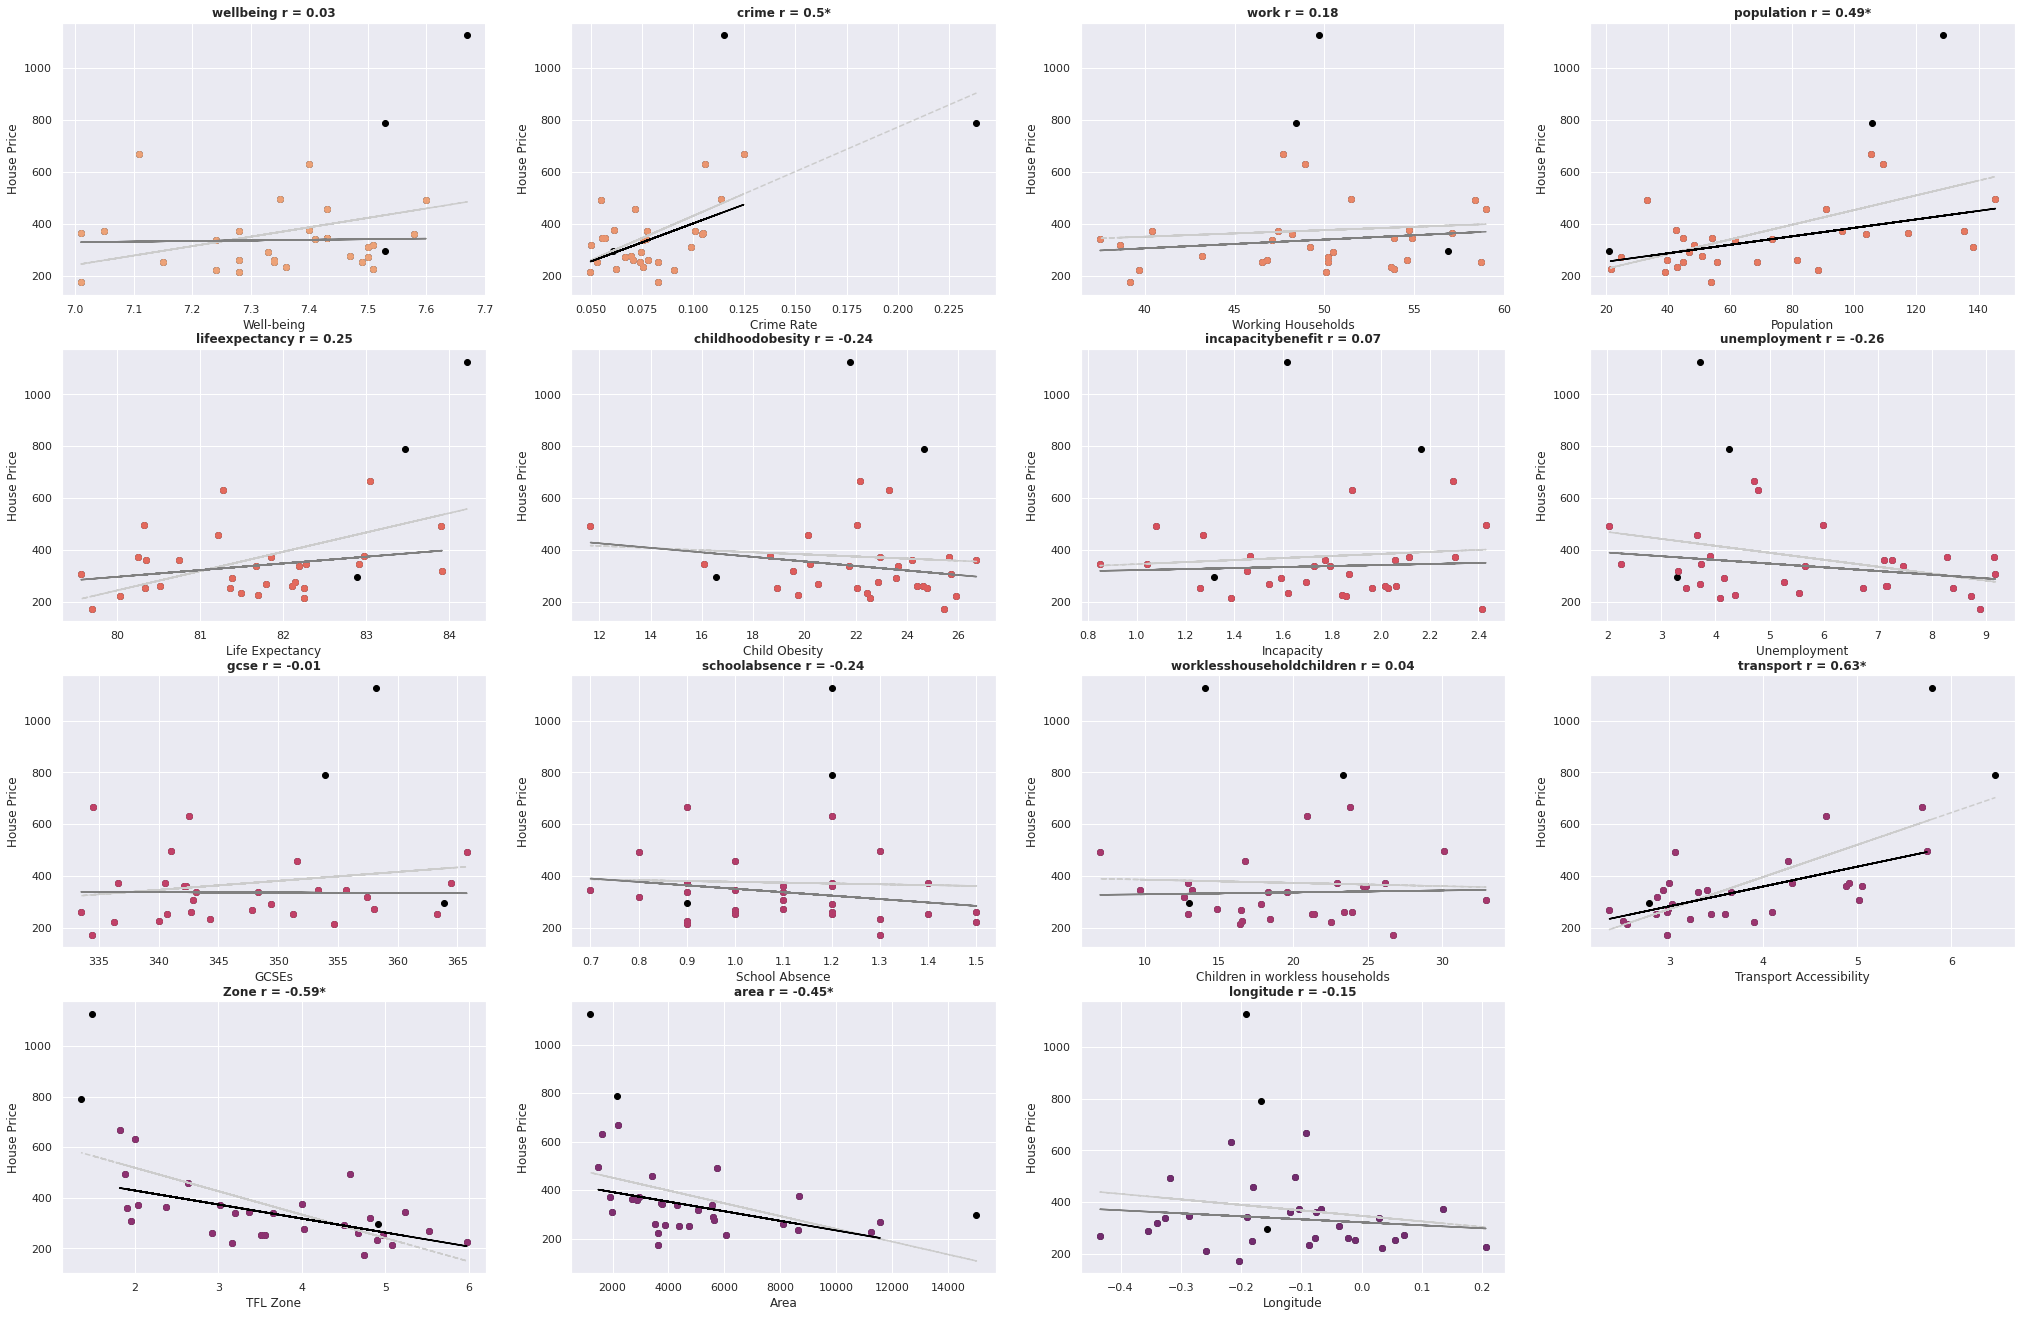

In [ ]:
#repeat plot without outliers
# each feature with target
sns.set(rc={'figure.figsize':(25,30)})
my_cmap = sns.color_palette('flare', n_colors = len(all_variables)+1)

count = 0
keep_corr = []
for feature in features:
  count += 1
  plt.subplot(6,4,count)
  df_x = features[feature]
  df_y = target.average_price
  plt.scatter(df_x,df_y,color=[0,0,0])
  corr, p = pearsonr(df_x,df_y)
  trendcolor = [.8, .8, .8]
  trend = np.polyfit(np.array(df_x, dtype='float'),
                    np.array(df_y, dtype='float'),1)
  trendpoly = np.poly1d(trend)
  plt.plot(df_x,trendpoly(df_x),color=trendcolor, linestyle='dashed')

  #without outliers
  df_x = features_new[feature]
  df_y = target_new.average_price
  plt.scatter(df_x,df_y,color=my_cmap[count-1])
  corr, p = pearsonr(df_x,df_y)
  keep_corr.append(corr)
  trendcolor = [.5, .5, .5]
  pstr = ''
  if p < .05:
    trendcolor = [0, 0, 0]
    pstr='*'
  trend = np.polyfit(np.array(df_x, dtype='float'),
                    np.array(df_y, dtype='float'),1)
  trendpoly = np.poly1d(trend)
  plt.plot(df_x,trendpoly(df_x),color=trendcolor)
  plt.title(feature + ' r = ' + str(round(corr,2))+pstr,fontweight='bold')
  plt.xlabel(titles[count-1])
  plt.ylabel('House Price')

The removed outliers are shown as black dots. The previous correlations are shown in light grey. We can see that, while some relationships have changed in value, their directions and overall magnitude all remained largely stable.

# 4) Feature Selection

To start to build a model for London house pricing, we have to select which of the variables is likely to predict property prices. Since we only observed a relationship with house pricing in four of our features, we will focus on these going forward. 

In [ ]:
# drop features with no sig. relationship to house prices
features = features_new.copy().astype(float)
target = target_new.copy().astype(float)

count = 0
for feature in features:
  if abs(keep_corr[count]) < .1:
    features = features.drop(columns=feature)
    print(feature)
  count += 1


wellbeing
incapacitybenefit
gcse
worklesshouseholdchildren


We expect that some of our features are related to each other and capture the same underlying phenomena. Since this can cause problems for our regression model, we'll first check for mutlicollinearity by plotting bivariate relationships between each set of features and by inspecting the variance inflation factor.

Variance inflation factor per feature:


,feature,VIF
0,crime,178.379484
1,work,119.052458
2,population,113.057169
3,lifeexpectancy,636.260755
4,childhoodobesity,203.924778
5,unemployment,46.269380
6,schoolabsence,79.013454
7,transport,759.587059
8,Zone,109.320964
9,area,17.346644


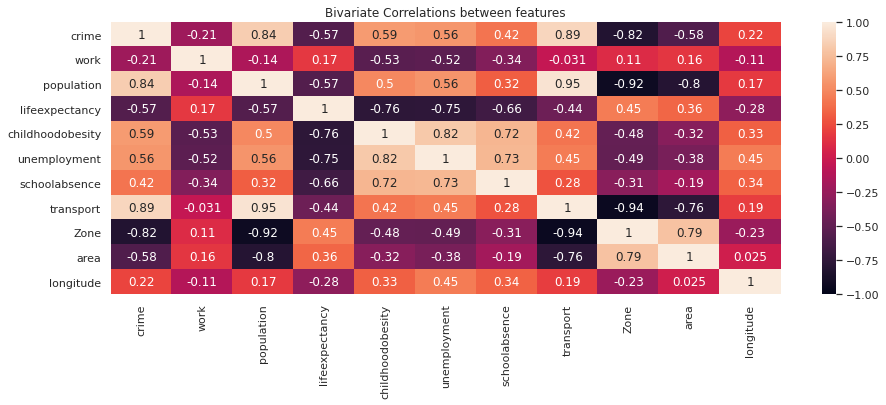

In [ ]:
# Check multicollinearity

#bivariate correlations
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(features.astype(float).corr(),vmin=-1,vmax=1,annot=True)
plt.title('Bivariate Correlations between features')
  
# variance inflation factor 
variance_inflation = pd.DataFrame() 
variance_inflation["feature"] = features.columns 
variance_inflation["VIF"] = [variance_inflation_factor(features.values, i) 
                             for i in range(len(features.columns))] 
print('Variance inflation factor per feature:')
variance_inflation

We can see that have very large variance inflation factors and strong relationships between many of the features. 
Given the extent of the multicollinearity issue, we'd likely lose too much data trying to remove it. Instead, we will use a model which is less affected by multicollinearity, i.e. a ridge regression.

(We'll nevertheless remove the 'work' variable. Although it doesn't come out as the worst offender in the mutlicollinearity measures, it makes intuitive sense that is captures the same underlying variable as 'unemployment').


In [ ]:
#drop features 
features = features.drop(	columns=['work'])

We're now ready to build a model.



---
# 5) Model



We now have the following features left to help us predict London house prices:

In [ ]:
for feature in features:
  print(feature)

crime
population
lifeexpectancy
childhoodobesity
unemployment
schoolabsence
transport
Zone
area
longitude


To fit a model, we'll first split the data into training and testing sets. 
We'll also plot the relationships between all remaining features and the target for one last sanity check.

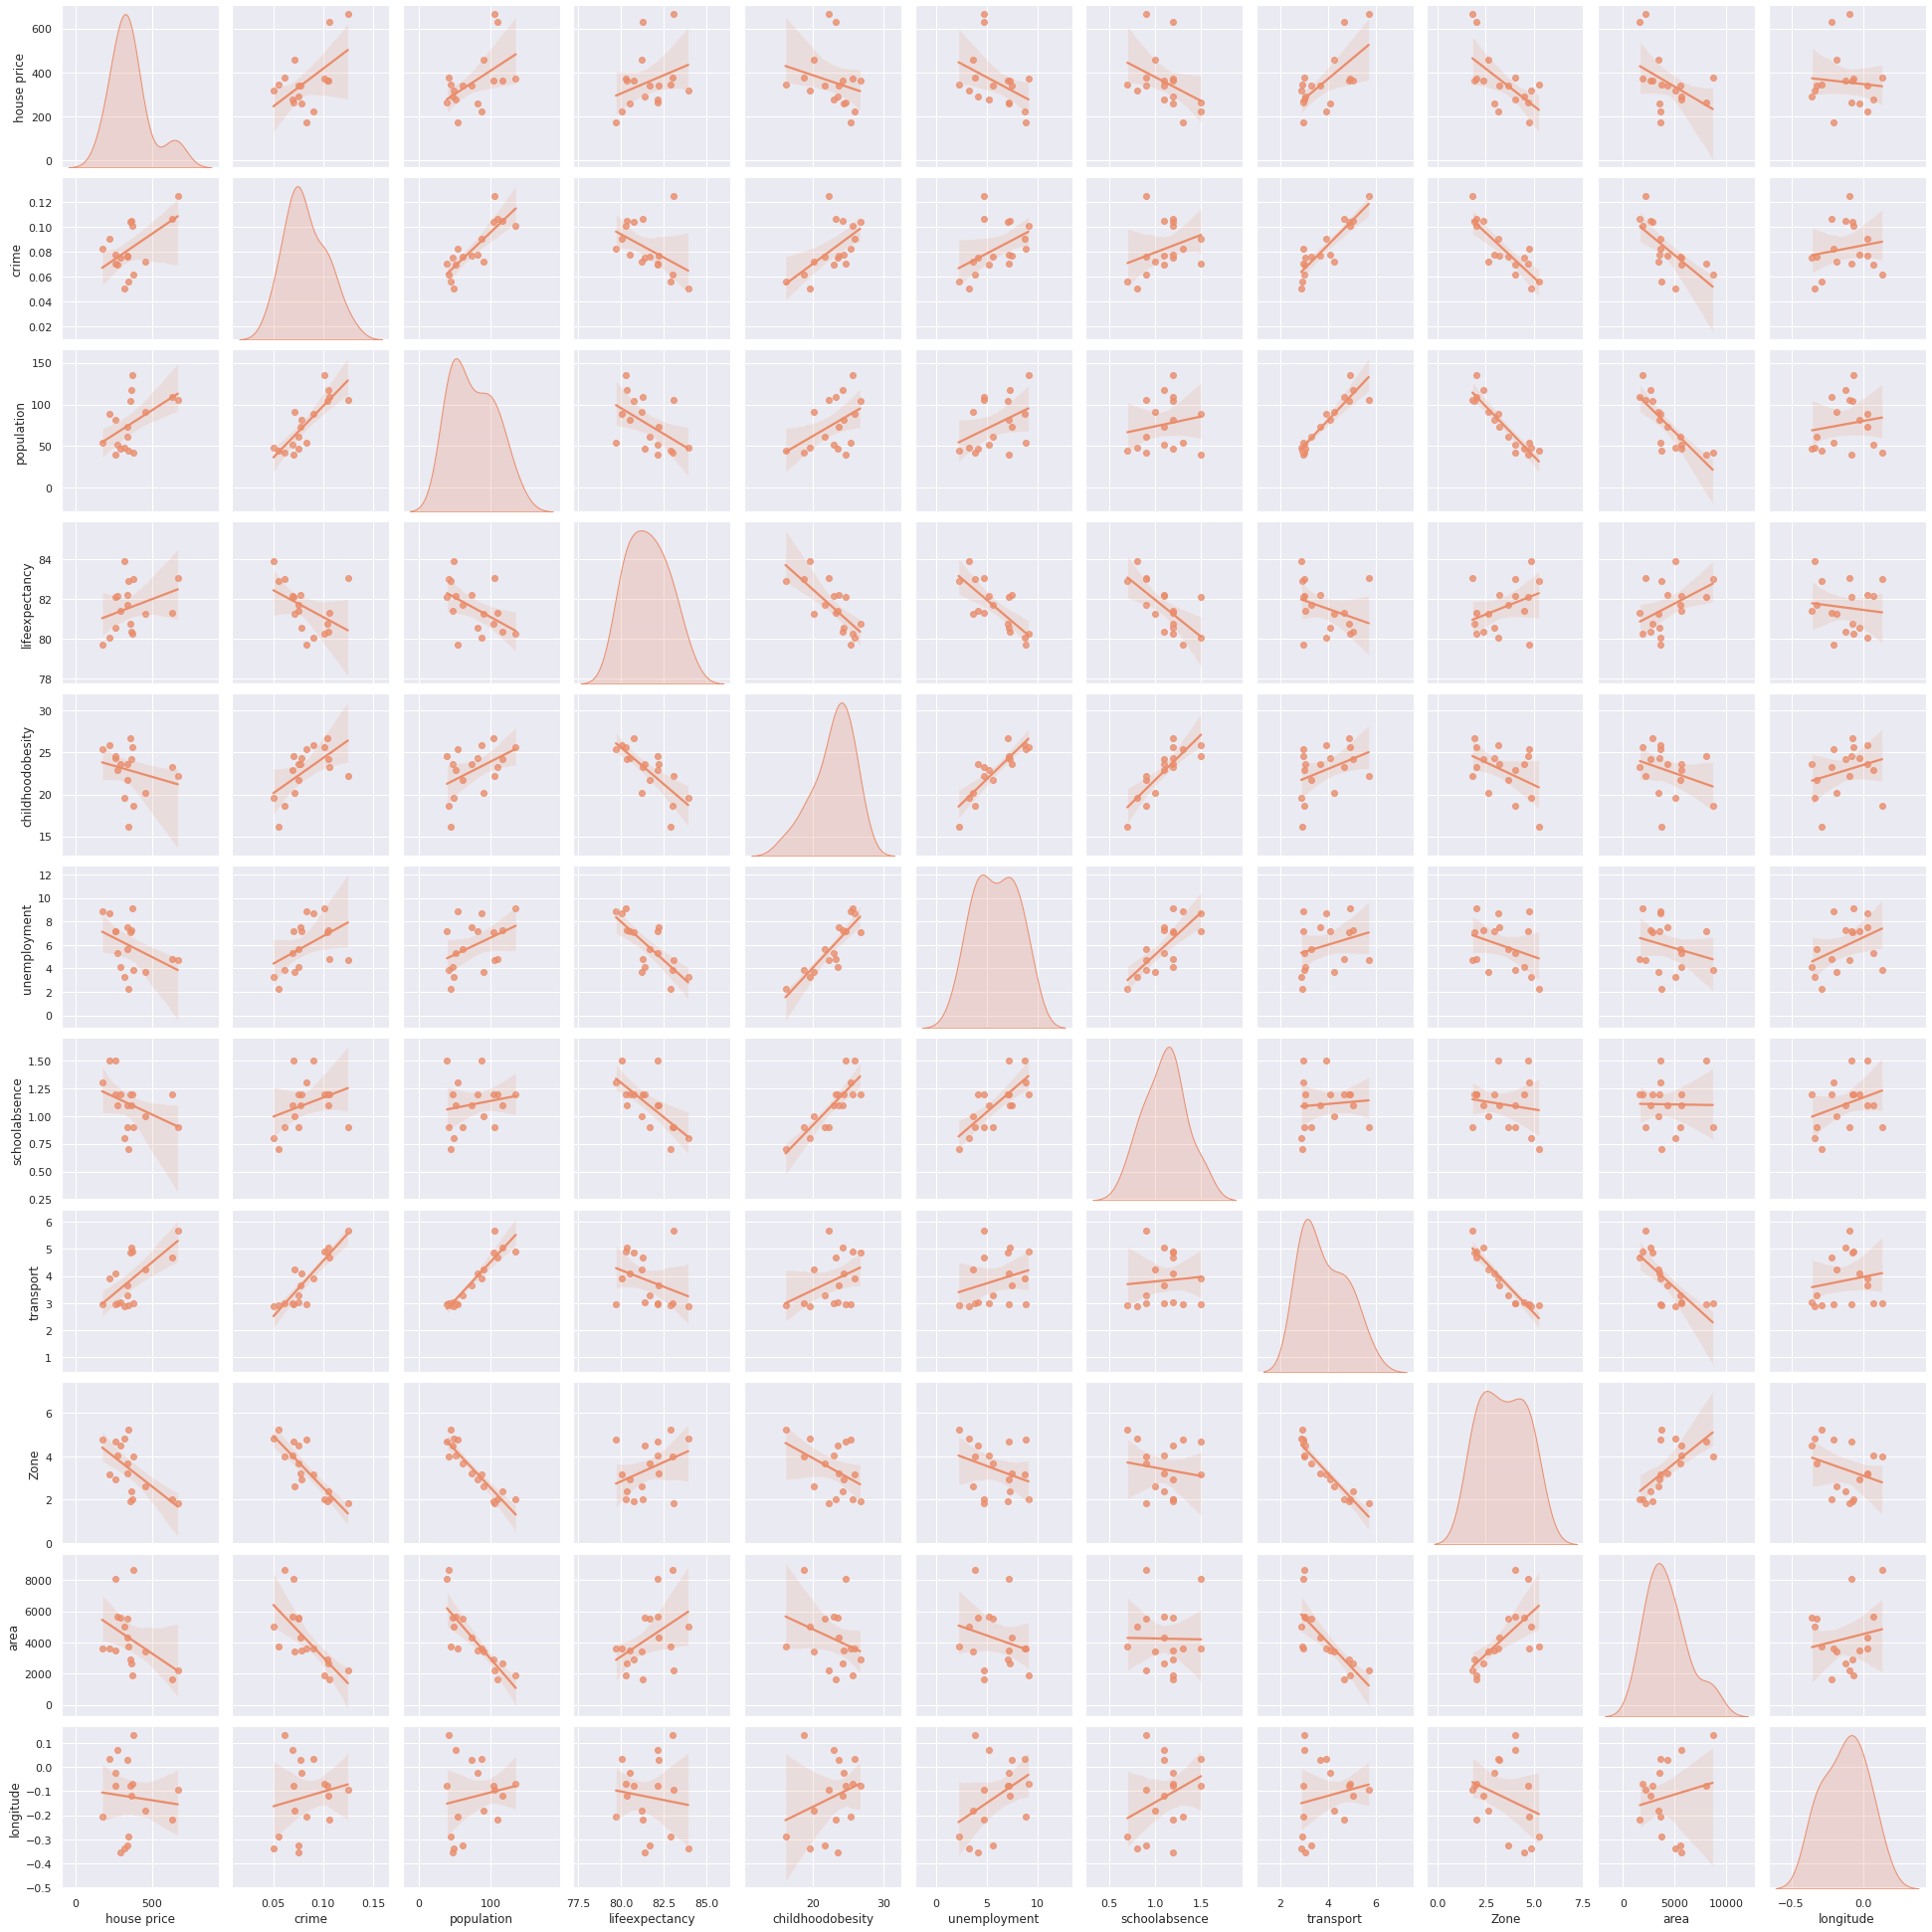

In [ ]:
#split train/test sets
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                    test_size=0.4, 
                                                    random_state=0)
# plot
sns.set_palette('flare')
train_dataset = X_train.copy()
train_dataset.insert(0, 'house price', y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

Now we'll fit our model and predict our test set.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


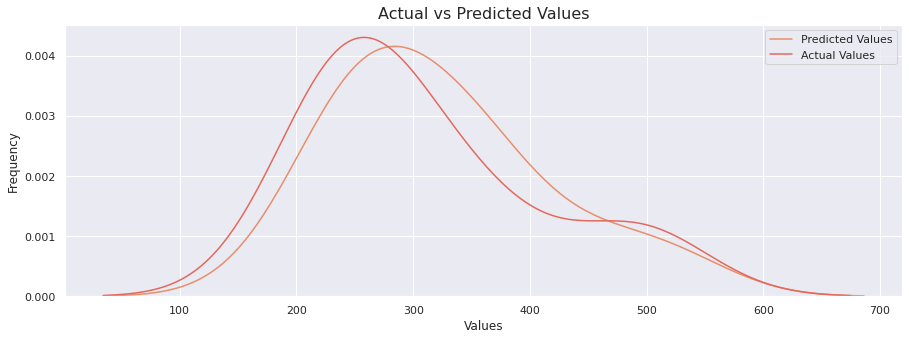

In [ ]:
# Ridge Regression with cross-validation of alpha hyperparameter
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
#prepare fold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
regr = RidgeCV(alphas=arange(0, 2, 0.1), cv=cv, normalize=True,
               scoring='neg_mean_absolute_error')
# fit model
regr.fit(X_train, y_train)
#predict test set
train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
test_set_r2 = r2_score(y_test, y_pred)
train_set_r2 = r2_score(y_train, train_pred)
#plot
sns.set_palette('flare')
sns.distplot(y_pred, hist = False, label = 'Predicted Values')
sns.distplot(y_test, hist = False,  label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend(loc = 'upper right')

We can see that our model is more or less able to predict the distribution of the test set. 

Let's have a closer look at the model parameters.

In [ ]:
# print coefficients
#print(regr.alpha_)
count =0
print('Coefficients:')
for feature in features:
  print('  '+feature+':'+ str(round(regr.coef_[0][count],2)))
  count+= 1

print('')
print('RMSE: ' + str(round(test_set_rmse,2))) 
print('')
print('Train R2: '+ str(round(train_set_r2,2))) 
print('')
print('Test R2: '+ str(round(test_set_r2,2))) 


Coefficients:
  crime:1893.97
  population:0.45
  lifeexpectancy:27.32
  childhoodobesity:-7.5
  unemployment:-17.07
  schoolabsence:1.42
  transport:26.44
  Zone:-28.96
  area:-0.0
  longitude:-44.17

RMSE: 34.1

Train R2: 0.86

Test R2: 0.87


These are the main points we can claim based on this output:
- Based on the signs of the coefficients, we can see that crime rates, population density, life expectancy, school absence, and transport accessibility have *positive* relationships with house prices, while childhood obesity, unemployment, TFL zone, area, and longitude have *negative* relationships with house prices. Note that these ar describing the relationships between a given feature and the target, *keeping all other features constant*, and are not necessarily the same as in the plot aboce. Note also that the magnitudes of the coefficients are unit-dependent and are not directly comparable.
- The R2 value for the training and test sets are almost identical, which suggests that we did not overfit our data.
- The R2 value of around .86 indicates that our model accounts for roughly 86% of the variability in the house prices in our data. Given the size of our dataset, this is a good outcome.



---
# Summary
- We loaded a number of different datasets which may capture variables which have an impact on house prices, such as variables related to socioeconomic status and infrastructure
- We built a model to predict house prices per borough using the following characteristics:
> - Crime Rates
> - Population Density
> - Life Expectancy
> - Rates of Childhood Obesity
> - Unemployment Rates
> - Rates of Unauthorised Absences from School
> - Transport Accessibility
> - Transport for London Zone Number
> - Area 
> - Longitude
- Although our model performed fairly well, we would need larger datasets to run more sophisticated or more generalisable models.

---



